# Vehicle Routing Problem (VRP)

The Vehicle Routing Problem (VRP) is a combinatorial optimization problem that aims to determine the optimal routes for a fleet of vehicles to deliver goods to a set of locations while minimizing the total distance traveled or cost incurred. The problem is NP-hard, meaning that finding an exact solution is computationally infeasible for large instances, and heuristic or approximation algorithms are often used to find near-optimal solutions.

The tutorial showcases how to solve the problem using the Quantum Approximate Optimization Algorithm (QAOA).

In the problem, each vehicle start from a different depot, visits a set of cities, and returns to its depot. The goal is to minimize the total travel cost while ensuring that each city is visited exactly once by one vehicle.

## Mathematical formulation

We are given:

- A set of locations:
    $L = {0, 1, \dots, n-1}$<br>
    Where the first $m$ locations are depots:<br>
    $D = {0, 1, \dots, m-1}$<br>
    The remaining $n - m$ are cities:<br>
    $C = {m, m+1, \dots, n-1}$
- Each vehicle $k \in D$:<br>
    - Starts and ends its route at its own depot $k$.
    - Visits a sequence of cities.
    - Returns to its depot.
- Each city must be visited exactly once by one vehicle only.
- Each vehicle route has $P = p + 2$ positions (start + $p$ inner positions + end). You can think about the positions as timesteps. We call the variable `positions` because driving between cities does not take the same amount of time.

### Decision Variables
Let $x_{u,v}^k \in \{0,1\}$ be a binary variable defined as:

$$
x_{u,v}^k =
\begin{cases}
1 & \text{if vehicle } k \text{ visits location } u \text{ at position } v \\
0 & \text{otherwise}
\end{cases}
$$

where:<br>
$u \in L$ (location: city or depot)<br>
$v \in {0, 1, \dots, P - 1}$<br>
$k \in D$ (vehicle/depot index)

### Constraints:
1. Each city is visited exactly once:
$$
\sum_{k\in D}\sum_{v=1}^{P-2} x_{u,v}^k = 1 \,\,\,\,\forall u\in C
$$
Each city appears in exactly one vehicle's route, and not at start or end positions.<br>
2. Each inner position is filled exactly once:
$$
\sum_{u\in C} x_{u,v}^k = 1 \,\,\,\,\forall v\in \{1,\dots,P-2\},\,\,\forall k\in D
$$

    Each vehicle has exactly one location assigned to each inner route position.<br>
3. Depot start and end positions are fixed:
$$
x_{k,0}^k = x_{k,P-1}^k = 1 \,\,\,\, \forall k\in D
$$
$$
x_{u,0}^k = x_{u,P-1}^k = 0 \,\,\,\, for \,\,\, u\neq k
$$
Each vehicle starts and ends at its own depot only.

4. No city at start or end:
$$
x_{u,0}^k = x_{u,P-1}^k = 1 \,\,\,\, \forall u\in C \,\,\,\, \forall k\in D
$$
    **For constraints (3) and (4), we do not use qubits in the QAOA circuit, because they are pre-determined.** 


### Objective function

We aim to minimize total travel cost, defined as:

$$
\min_x \quad \sum_{k \in D} \sum_{v = 0}^{P - 2} \sum_{u \in L} \sum_{w \in L} \text{dist}(u, w) \cdot x_{u,v}^k \cdot x_{w,v+1}^k
$$

Where:
- $\text{dist}(u, w)$ is the Euclidean distance between location $u$ and $w$.
- The sum computes all transitions $(u \rightarrow w)$ for each vehicle between consecutive positions.

### Constraint reinforcement function

All cities visited only once:

$$
\sum_{u \in C} \left( \sum_{k \in D} \sum_{v=0}^{P-2} x_{u,v}^k -1 \right)^2=0
$$

All positions are occupied only once:

$$
\sum_{k \in D} \sum_{v=1}^{P-2} \left(\sum_{u \in C} x_{u,v}^k -1 \right)^2=0
$$

**These are added as penalty terms and multiplied by a scaling factor later in the notebook at the `objective` function. We ensure they will are actually equal to zero by adding them as penlty terms.**

## Generating problem data

In [38]:
import math
from typing import Iterable

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.optimize import minimize

from classiq import *

locations = list(range(6))

# one depot per car
depots = list(range(2))

# 4 cities to visit in total
cities = list(range(2, 6))

num_vehicles = len(depots)
num_cities = len(cities)
num_locations = len(locations)

### Definition of positions
Assuming the cities are evenly divided among vehicles (more or less), we will use `possible_number_of_cities_per_vehicle`.

In [39]:
possible_number_of_cities_per_vehicle = len(cities) // num_vehicles

The total number of positions `num_positions` (or time slots) in a car route. We add $2$ for the start (depot) and end (return to depot) positions.

In [40]:
num_positions = possible_number_of_cities_per_vehicle + 2

All valid routes (time slots) positions that a vehicle can take:
- Starting depot $\rightarrow 0$
- Visiting cities $\rightarrow 1,2, \ldots,$ `num_positions-1`
- Ending depot $\rightarrow$ `num_positions`

In [41]:
positions_all = list(range(num_positions))

In [42]:
print(positions_all)

[0, 1, 2, 3]


The inner positions are the positions that can be occupied by cities, excluding the start and end depots.

In [43]:
inner_positions = list(range(1, num_positions - 1))

print(inner_positions)

[1, 2]


### Setting locations of cities

Setting random locations in a square of size `(0, max_x_y)`$\times$`(0, max_x_y)`.
To have the same result, we set the random seed. To have different results, change/delete the seed.

In [44]:
np.random.seed(10)

max_x_y = 10
x_y_locations = np.random.rand(num_locations, 2) * max_x_y

Text(0.5, 1.0, 'Graph of the Cities on the XY Plane')

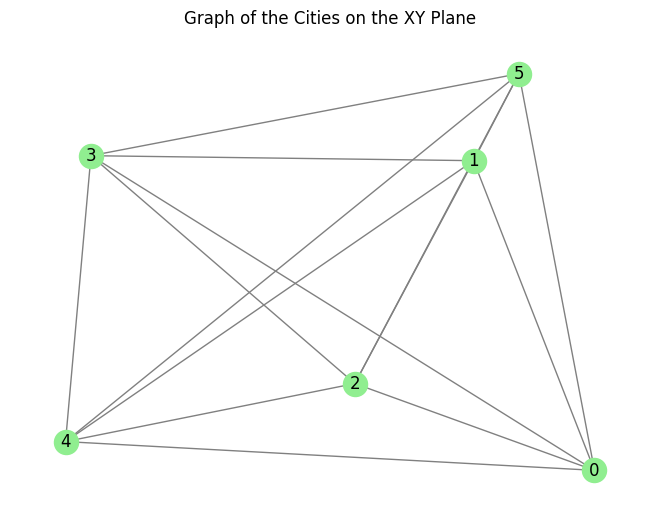

In [45]:
# Create a complete graph
G = nx.complete_graph(num_locations)

# Map node positions to the generated x_y coordinates
pos = {i: (x_y_locations[i][0], x_y_locations[i][1]) for i in range(num_locations)}

# Plot
nx.draw(
    G, pos, with_labels=True, node_size=300, node_color="lightgreen", edge_color="gray"
)
plt.title("Graph of the Cities on the XY Plane")

In [46]:
def find_xy_distances_from_locations(x_y_locations: np.ndarray):
    city_distance_matrix = np.zeros((num_locations, num_locations))
    for i in range(num_locations):
        for j in range(num_locations):
            distance = math.sqrt(
                (x_y_locations[i][0] - x_y_locations[j][0]) ** 2
                + (x_y_locations[i][1] - x_y_locations[j][1]) ** 2
            )
            city_distance_matrix[i][j] = distance
    return city_distance_matrix


def calculate_distances_between_cities(x_y_locations: np.ndarray):
    city_distance_matrix = find_xy_distances_from_locations(x_y_locations)
    max_distance = np.max(city_distance_matrix)
    min_distance = np.min(
        city_distance_matrix[city_distance_matrix > 0]
    )  # Exclude self-distances
    return city_distance_matrix, max_distance, min_distance


city_distance_matrix, max_distance, min_distance = calculate_distances_between_cities(
    x_y_locations
)

In [47]:
print(city_distance_matrix)

[[ 0.          7.40954323  3.40678023  9.35893743  6.05990735  9.3659449 ]
 [ 7.40954323  0.          5.41153153  4.35743196  8.07469987  2.11023545]
 [ 3.40678023  5.41153153  0.          6.14229335  3.56542154  7.52174929]
 [ 9.35893743  4.35743196  6.14229335  0.          6.72814108  5.24074724]
 [ 6.05990735  8.07469987  3.56542154  6.72814108  0.         10.07388021]
 [ 9.3659449   2.11023545  7.52174929  5.24074724 10.07388021  0.        ]]


The maximal cost of any candidate is `num_locations`$\times$ `max_distance`.
The minimal cost of any candidate is `num_locations`$\times$ `min_distance`.
Hence, the maximal difference of eigenvalues of the total cost Hamiltonian is:

In [48]:
DISTANCE_NORMALISATION = num_locations * (max_distance - min_distance)

In order to set the maximal difference of eigenvalues of the total cost Hamiltonian to 1, we must scale the distances by `DISTANCE_NORMALISATION`:

In [49]:
city_distance_matrix = city_distance_matrix / DISTANCE_NORMALISATION

In [50]:
print(city_distance_matrix)

[[0.         0.15507019 0.0712986  0.19586797 0.12682441 0.19601462]
 [0.15507019 0.         0.11325492 0.09119426 0.16899088 0.04416394]
 [0.0712986  0.11325492 0.         0.12854862 0.07461871 0.15741848]
 [0.19586797 0.09119426 0.12854862 0.         0.1408095  0.10968067]
 [0.12682441 0.16899088 0.07461871 0.1408095  0.         0.2108306 ]
 [0.19601462 0.04416394 0.15741848 0.10968067 0.2108306  0.        ]]


## To find good solutions, we need to normalise the mixer and the cost Hamiltonians.
### If it is too much information, ignore it for now, and go to "Defining the VRP objective function" to focus on the VRP problem itself.
The mixer Hamiltonian is effectively $X/2$ and has eigenvalues $-0.5$ and $+0.5$. So the difference between minimum and maximum eigenvalues is exactly 1.
This can be rescaled by a global scaling parameter.

In [51]:
GLOBAL_SCALING_PARAMETER = 0.1

The cost Hamiltonian should be similar in eigenvalue difference to the mixer Hamiltonian and should be normalised to about 1.
This will be taken care off later by the distance normalisation.

To find the exact normalisation requires solving this NP hard problem, so we always use approximation. Since this is approximate, there is a relative scaling parameter we can tweak.

In [52]:
RELATIVE_COST_NORMALISATION = 1.5

The overall normalization of the total cost is thus:

In [53]:
ABSOLUTE_COST_NORMALISATION = GLOBAL_SCALING_PARAMETER * RELATIVE_COST_NORMALISATION
print(ABSOLUTE_COST_NORMALISATION)

0.15000000000000002


The constraint Hamiltonian has the property that a minimal constraint violation is 1 and no constraint violation is 0.
We wish to normalise the constraint Hamiltonian relative to the total cost Hamiltonian such that the constraint violation will be 1~2 x larger than the maximal difference between total cost values.

In [54]:
RELATIVE_CONSTRAINT_NORMALISATION = 6

The overall normalisation of the constraint Hamiltonian is similarly:

In [55]:
ABSOLUTE_CONSTRAINT_NORMALISATION = (
    RELATIVE_CONSTRAINT_NORMALISATION * ABSOLUTE_COST_NORMALISATION
)

print(ABSOLUTE_CONSTRAINT_NORMALISATION)

0.9000000000000001


## Defining the VRP objective function
### First, define number of functions that compose the objective function
### A major difficulty is to map 3D (city, position, vehicle) to 1D index in the array of decision variables.

#### Find the right index
Access the value of the binary decision variable x that encodes whether city (or depot) u is visited at position v by vehicle k.
`u`- city
`v` - position (time slot)
`x` is the array of decision variables
`k` is the vehicle number

In [56]:
def visit_indicator(
    x: QArray[QBit] | Iterable[int],  # array of decision variables
    u: int,  # city
    v: int,  # position
    k: int,  # vehicle number
) -> int | QBit:
    """
    Access the value of the binary decision variable x that encodes whether city (or depot) u is visited at position v by vehicle k.
    """
    if u in depots or (v == 0 or v == num_positions - 1):
        # Case 1: If `u` is a depot
        if u in depots:
            if k == u:
                # Depots are only valid at start or end positions
                if v == 0 or v == num_positions - 1:
                    # Vehicle `k` starts or ends at its depot `u`
                    return 1
                else:
                    return 0
            else:
                return 0
        # Case 2: `u` is not a depot but the position is a depot-only position
        # Cities are not allowed at start or end of a route
        else:
            return 0
    # Handle city logic (when `u` is a city and `v` is an inner position)
    else:
        # We map 3D (city, position, vehicle) to 1D index
        city_index = u - num_vehicles
        pos_index = v - 1
        flat_index = (
            city_index * possible_number_of_cities_per_vehicle * num_vehicles
            + pos_index * num_vehicles
            + k
        )
        return x[flat_index]

Making sure we satisfy the following constraints:
1. Each city is assigned to exactly one vehicle and one route position.
2. Each inner position of a route (per vehicle) is filled by exactly one city.

In [57]:
def check_validity(x: QArray[QBit]):
    """
    verifies that the assignment array `x` satisfies basic constraints.
    Checks if each city is visited exactly once and by one vehicle.
    """
    # Check that each city is visited exactly once
    for city_index in range(num_cities):
        assignment_sum = 0

        for position in range(
            possible_number_of_cities_per_vehicle
        ):  # inner positions only
            for vehicle_id in range(num_vehicles):
                # Shift city index by num_vehicles to access location ID (since cities start after depots)
                assignment_sum += visit_indicator(
                    x=x, u=city_index + num_vehicles, v=position + 1, k=vehicle_id
                )

        # A city must appear exactly once across all vehicles and positions
        if assignment_sum != 1:
            return False

    # Each position is used exactly once per vehicle
    for position in range(possible_number_of_cities_per_vehicle):  # inner positions
        for vehicle_id in range(num_vehicles):
            assignment_sum = 0

            for city_index in range(num_cities):
                assignment_sum += visit_indicator(
                    x=x, u=city_index + num_vehicles, v=position + 1, k=vehicle_id
                )

            # Each position must be occupied by exactly one city
            if assignment_sum != 1:
                return False

    return True

### Total travel cost for all vehicle routes

In [58]:
def total_travel_cost4vehicles(x: QArray[QBit]):
    """
    Computes the total travel cost for all vehicle routes defined by the assignment array `x`.

    The cost is calculated as the sum of the distances between every pair of consecutive locations
    visited by the same vehicle, across all route positions.
    """
    total_travel_cost = 0

    # Loop through each position in the route except the last (we look ahead to position + 1)
    for position in range(num_positions - 1):

        # Consider every pair of locations (from → to)
        for to_location in locations:
            for from_location in locations:
                # For each vehicle (indexed by its depot ID)
                for vehicle_id in depots:

                    # Add cost only if both transitions are selected in the route
                    total_travel_cost += (
                        ABSOLUTE_COST_NORMALISATION
                        * city_distance_matrix[from_location][to_location]
                        * visit_indicator(x, from_location, position, vehicle_id)
                        * visit_indicator(x, to_location, position + 1, vehicle_id)
                    )

    return total_travel_cost

## Defining the constraints

In [59]:
def constraint_each_city_visited_once(x: QArray[QBit]):
    """
    Soft constraint: Ensures that each city is visited exactly once by applying a penalty
    for any deviation from that condition.

    For each city, it checks how many times the city appears across all vehicle routes and
    inner positions. If the count is not exactly one, a quadratic penalty is applied.
    """
    total_penalty = 0

    # Loop over each city (cities are defined separately from depots)
    for city_id in cities:
        city_assignment_count = 0

        # Sum appearances of this city across all vehicles and inner positions
        for vehicle_id in depots:
            for position in inner_positions:
                city_assignment_count += visit_indicator(
                    x=x, u=city_id, v=position, k=vehicle_id
                )

        # Ideal count is 1: each city should be visited exactly once
        deviation_from_expected = city_assignment_count - 1

        # Apply a quadratic penalty for deviation (0 if exactly one visit)
        penalty = ABSOLUTE_CONSTRAINT_NORMALISATION * (deviation_from_expected**2)

        total_penalty += penalty

    return total_penalty


def constraint_each_position_occupied_by_one_city(x: QArray[QBit]):
    """
    Soft constraint: Ensures that each inner position in each vehicle's route is occupied
    by exactly one location (either a city or a depot).

    For each vehicle and each inner route position, the function counts how many locations
    are assigned to that slot. If the count is not exactly one, a penalty is applied.
    """
    total_penalty = 0

    # Loop through each inner position (excluding start and end depot slots)
    for position in inner_positions:

        # Check each vehicle's route at this position
        for vehicle_id in depots:
            position_occupancy_count = 0

            # Sum over all possible locations (cities + depots) at this position
            for location_id in locations:
                position_occupancy_count += visit_indicator(
                    x=x, u=location_id, v=position, k=vehicle_id
                )

            # Each position must be occupied by exactly one location
            deviation_from_expected = position_occupancy_count - 1

            # Apply a penalty for under/over-assignments
            penalty_term = deviation_from_expected**2
            total_penalty += penalty_term

    # Apply the penalty with the normalisation factor
    return ABSOLUTE_CONSTRAINT_NORMALISATION * total_penalty

#### Total objective function for the VRP is the sum of the total travel cost and the constraints.

In [60]:
def objective(x: QArray[QBit]):
    return (
        total_travel_cost4vehicles(x)
        + constraint_each_city_visited_once(x)
        + constraint_each_position_occupied_by_one_city(x)
    )

## Let's start building the QAOA model
#### Define the number of layers

In [61]:
NUM_LAYERS = 12


@qfunc
def mixer_layer(beta: CReal, qba: QArray[QBit]):
    apply_to_all(lambda q: RX(GLOBAL_SCALING_PARAMETER * beta, q), qba),


@qfunc
def main(params: CArray[CReal, 2 * NUM_LAYERS], x: Output[QArray[QBit]]) -> None:
    allocate((num_locations - 2) * (num_positions - 2) * len(depots), x)
    hadamard_transform(x)

    for i in range(NUM_LAYERS):
        phase(expr=objective(x), theta=params[2 * i]),
        mixer_layer(params[2 * i + 1], x)

## Synthesizing the model

In [62]:
qprog = synthesize(model=main)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/315SSZgxtT9XAes7tt8BCZisgrP


## After we have the QAOA circuit, we can execute it in the hybrid scheme
### Defining the `ExecutionSession` for the optimization process
### Defining the initial parameters

In [63]:
NUM_SHOTS = 30000

es = ExecutionSession(
    qprog, execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
)


def initial_qaoa_params(NUM_LAYERS) -> np.ndarray:
    initial_gammas = math.pi * np.linspace(
        1 / (2 * NUM_LAYERS), 1 - 1 / (2 * NUM_LAYERS), NUM_LAYERS
    )
    initial_betas = math.pi * np.linspace(
        1 - 1 / (2 * NUM_LAYERS), 1 / (2 * NUM_LAYERS), NUM_LAYERS
    )

    initial_params = []

    for i in range(NUM_LAYERS):
        initial_params.append(initial_gammas[i])
        initial_params.append(initial_betas[i])

    return np.array(initial_params)


initial_params = initial_qaoa_params(NUM_LAYERS)

### Defining the cost function for the execution
For each measurement state, the cost function is calculated by the `objective` function of the VRP problem.

In [64]:
cost_func = lambda state: objective(state["x"])

### Define the function to estimate the cost function of each iteration
This is done by the `estimate_cost` method of the `ExecutionSession` class.

In [65]:
# Record the steps of the optimization
intermediate_params = []
objective_values = []


def estimate_cost_func(params):
    objective_val = es.estimate_cost(cost_func, {"params": params.tolist()})
    objective_values.append(objective_val)
    return objective_val


# Define the callback function to store the intermediate steps
def callback(xk):
    intermediate_params.append(xk)

### Running the optimization process
Using `scipy.optimize.minimize` to minimize the cost function.

#### You may increase the `max_iterations` to have more iterations

In [66]:
max_iterations = 1

optimization_res = minimize(
    fun=estimate_cost_func,
    x0=initial_params,
    method="COBYLA",
    callback=callback,
    options={"maxiter": max_iterations, "rhobeg": 0.7},
)

## Analyzing the results
### Make a convergences graph if you have more iterations

In [67]:
# plt.plot(objective_values)
# plt.xlabel("Iteration")
# plt.ylabel("Objective Value")
# plt.title("Optimization Progress")

### See optimized parameters
It is relevant to watch for 4 or more circuit layers.

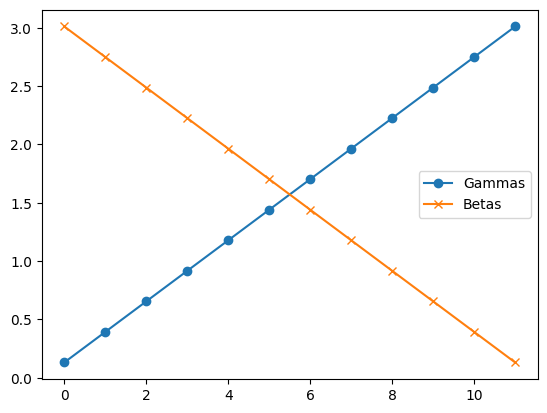

In [68]:
optimized_gammas = optimization_res.x[0::2]
optimized_betas = optimization_res.x[1::2]

plt.plot(optimized_gammas, label="Gammas", marker="o")
plt.plot(optimized_betas, label="Betas", marker="x")
plt.legend()

Accumulating the statistic with the final optimized parameters

In [69]:
res = es.sample({"params": optimization_res.x.tolist()})

In [70]:
sorted_counts = sorted(res.parsed_counts, key=lambda pc: objective(pc.state["x"]))

for sampled in sorted_counts[:20]:
    x = sampled.state["x"]
    if check_validity(x):

        print(
            f"\033[92msolution={sampled.state['x']} probability={sampled.shots/NUM_SHOTS} cost={objective(sampled.state['x'])}\033[0m"
        )
    else:
        print(
            f"\033[91msolution={sampled.state['x']} probability={sampled.shots/NUM_SHOTS} cost={objective(sampled.state['x'])}\033[0m"
        )

solution=[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1] probability=0.0015 cost=0.07766708749355561
solution=[0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0] probability=0.0014666666666666667 cost=0.07766708749355561
solution=[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0] probability=0.0011666666666666668 cost=0.07766708749355561
solution=[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1] probability=0.0012666666666666666 cost=0.07766708749355562
solution=[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1] probability=0.0016666666666666668 cost=0.11675088242357473
solution=[0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0] probability=0.0015333333333333334 cost=0.11675088242357473
solution=[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1] probability=0.0013333333333333333 cost=0.11675088242357473
solution=[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0] probability=0.0012 cost=0.11675088242357473
solution=[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0] probability=0.0017 cost=0.1229550906

### The best solution found

In [71]:
sorted_counts[0]

{'x': [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]}: 45

In [72]:
visited_cities_by_vehicle = {}

for vehicle in depots:
    print("Vehicle:", vehicle)
    visited_cities_by_vehicle[vehicle] = []  # Initialize list for this vehicle

    for position in positions_all:
        for city in locations:
            if visit_indicator(sorted_counts[0].state["x"], city, position, vehicle):
                print(f"Visited in city {city} at position {position}")
                visited_cities_by_vehicle[vehicle].append(city)

Vehicle: 0
Visited in city 0 at position 0
Visited in city 2 at position 1
Visited in city 4 at position 2
Visited in city 0 at position 3
Vehicle: 1
Visited in city 1 at position 0
Visited in city 3 at position 1
Visited in city 5 at position 2
Visited in city 1 at position 3


Text(0.5, 1.0, 'Cities Colored by the visited vehicle')

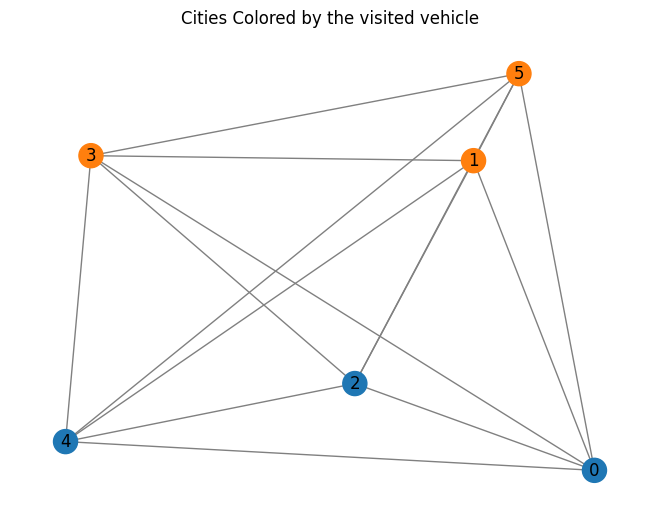

In [73]:
G = nx.complete_graph(num_locations)

color_map = plt.colormaps["tab10"]  # or 'tab20', 'Set3', etc.
vehicle_colors = {vehicle: color_map(i) for i, vehicle in enumerate(depots)}

# Assign each city a color based on the vehicle that visited it
city_colors = [None] * num_locations
for vehicle, cities in visited_cities_by_vehicle.items():
    for city in cities:
        city_colors[city] = vehicle_colors[vehicle]

# Plot the graph
nx.draw(
    G, pos, with_labels=True, node_size=300, node_color=city_colors, edge_color="gray"
)
plt.title("Cities Colored by the visited vehicle")